# Recommender system exercises

You'll need to install the packages pandas and matplotlib for this exercise.

We're working with the movielens data set, the smaller version. This data set contains 100k ratings for 9000 movies from 600 users.

We'll have a look at the data, implement collaborative filtering, and look at some typical metrics.

## Getting the data

Uncomment the lines in the next box and this will download the files and unzip them in this directory.


In [1]:
# Do this only once!
#!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
#!unzip ml-latest-small.zip

These are the includes for the rest of the notebook

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl

## Reading the movie data

Let's start by reading the movie data and define a function findMovieByTitle that returns all movies which match a given string.

We'll use the [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) library for loading. Key to performance is to not manually iterate over the data, but use built-in functions as much as possible.

In [3]:
movies = pd.read_csv('ml-latest-small/movies.csv', index_col='movieId') # why is it called index_col, not index

Implement a function findMovieByTitle that returns all movies whose title matches the string passed.

Then, let's return all movies containing the term 'Matrix'

In [4]:
# a function to do some exploration
def findMovieByTitle(title):
    return movies[movies.title.str.find(title) != -1]

findMovieByTitle('Matrix')

,title,genres
movieId,,
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
6365,"Matrix Reloaded, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
6934,"Matrix Revolutions, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX


## Reading the ratings data

Next, we'll load the ratings data set. Use datetime.datetime.fromtimestamp to convert the timestamp column to an actual datetime object (this will make it more readable)

In [5]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.timestamp = ratings.timestamp.apply(datetime.datetime.fromtimestamp) # datetime.datetime WTF

userIds = ratings.userId.unique()

Now, define a function ratingsForUser that takes a user id and returns all the entries from the ratings table for that user.

In [6]:
# again, another function to find some data
def ratingsForUser(uid):
    return ratings[ratings.userId == uid]

ratingsForUser(20)

,userId,movieId,rating,timestamp
2977,20,2,3.0,2003-05-27 14:25:13
2978,20,8,1.0,2003-05-27 14:27:02
2979,20,13,4.0,2003-05-27 14:27:05
2980,20,34,4.0,2003-05-27 14:21:33
2981,20,48,5.0,2003-05-27 14:25:57
...,...,...,...,...
3214,20,6297,4.0,2003-05-27 13:57:50
3215,20,6333,4.0,2003-05-27 13:56:56
3216,20,6345,5.0,2003-05-27 13:57:03
3217,20,6358,3.5,2003-05-28 20:45:05


Let's do some data exploration. Compute the number of ratings per user and plot the histogram. Hint, use the [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) function from pandas. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63ee7a45b0>,
      dtype=object)

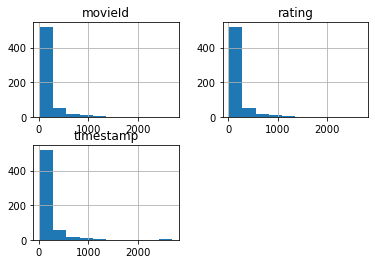

In [7]:
# compute a histogram of number of ratings.
number_of_ratings = ratings.groupby(['userId']).count()
number_of_ratings.hist()

This data set looks highly skewed as often the case. Most users have only a small number of ratings. What is the minimum number of ratings in the data set?

In [8]:
number_of_ratings.rating.min()

20

What is the movie with the most views?

In [9]:
number_of_views = ratings.groupby(['movieId']).userId.count()
movies[movies.index == number_of_views.idxmax()]

,title,genres
movieId,,
356,Forrest Gump (1994),Comedy|Drama|Romance|War


This is a all not very informative. Try joining the movies data to this result set so that you can see the title and the other columns as well. (Hint: you need to use the 'on=' keyword in the join function)

In [10]:
movies.join(ratings, on='movieId')

,title,genres,userId,movieId,rating,timestamp
movieId,,,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,3.0,4.0,2000-07-30 20:20:47
2,Jumanji (1995),Adventure|Children|Fantasy,1.0,6.0,4.0,2000-07-30 20:37:04
3,Grumpier Old Men (1995),Comedy|Romance,1.0,47.0,5.0,2000-07-30 21:03:35
4,Waiting to Exhale (1995),Comedy|Drama|Romance,1.0,50.0,5.0,2000-07-30 20:48:51
5,Father of the Bride Part II (1995),Comedy,1.0,70.0,3.0,2000-07-30 20:40:00
...,...,...,...,...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,NaN,NaN,NaN,NaT
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,NaN,NaN,NaN,NaT
193585,Flint (2017),Drama,NaN,NaN,NaN,NaT


Likewise, what's the best rated movie of all times?

In [11]:
number_of_views = ratings.groupby(['movieId']).rating.max()
movies[movies.index == number_of_views.idxmax()]

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


The top seems to be movies with very few ratings, only look at movies that have twenty or more ratings.

In [12]:
twenty_or_more_ratings = ratings.groupby(['movieId']).rating.count() >= 20
movies[movies.join(twenty_or_more_ratings, on='movieId').rating == True]

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
5,Father of the Bride Part II (1995),Comedy
6,Heat (1995),Action|Crime|Thriller
...,...,...
148626,"Big Short, The (2015)",Drama
152081,Zootopia (2016),Action|Adventure|Animation|Children|Comedy
164179,Arrival (2016),Sci-Fi


# Toy data

Before we go into working on collaborative filtering, let's define a toy data set. This is generally good practice if you are working with real-world data sets. Toy data is smaller and you can work faster, but you can also design it in a way that you know the outcome.

In [13]:
toyratings = pd.DataFrame(data={
    'userId': [1, 1, 1, 1, 1,
              2, 2, 2,
              3, 3, 3],
    'movieId': [1,2,3,4,8,
               1,2,3,
               2,3,5],
    'rating': [5.0, 4.0, 3.0, 2.0, 1.0,
               1.0, 2.0, 3.0,
               3.0, 3.0, 3.0],
    'timestamp': ['2021-01-01 10:00', '2021-01-02 08:00', '2021-01-03 09:00', '2021-01-04 10:00', '2021-01-05 11:00',
                 '2021-01-10 08:00', '2021-01-11 09:00', '2021-01-13 10:00',
                '2021-01-07 08:00', '2021-01-09 09:00', '2021-01-11 10:00']
                  
})
toyratings

,userId,movieId,rating,timestamp
0,1,1,5.0,2021-01-01 10:00
1,1,2,4.0,2021-01-02 08:00
2,1,3,3.0,2021-01-03 09:00
3,1,4,2.0,2021-01-04 10:00
4,1,8,1.0,2021-01-05 11:00
5,2,1,1.0,2021-01-10 08:00
6,2,2,2.0,2021-01-11 09:00
7,2,3,3.0,2021-01-13 10:00
8,3,2,3.0,2021-01-07 08:00
9,3,3,3.0,2021-01-09 09:00


# Collaborative filtering

We will now (finally) implement collaborative filtering. For two movies, it looks at the ratings of all users and computes the cosine similarities between these vectors. It might sound simple, but works if you have sufficient amounts of data, and is often a good first version.

We're not dealing with this here, but for future reference: It is not personalized, and you don't know how to do recommendations for new items. There are other methods that look at customer events, or take content into account to deal with these kinds of problems. Factorization methods can also help if your data is very sparse.

Implement a function that takes the ratings dataframe and returns a dataframe which contains movie to movie similarities. You can convert the dataframe to a numpy array to work with matrix algebra. Try to avoid using explicit for loops.

In [378]:
from sklearn.metrics.pairwise import cosine_similarity

def collaborative_filtering(ratings):
    ratings_user_item = ratings.pivot_table(index='userId', columns='movieId', values='rating')
    # normalize
    #ratings_mean = ratings_user_item.mean(axis=1)
    #ratings_user_item = ratings_user_item.sub(ratings_mean, axis=0)
    ratings_user_item = ratings_user_item.fillna(np.finfo(np.float64).eps)
    ratings_user_item_np = ratings_user_item.to_numpy()
    # calculate the cosine similarity
    movies_norm = np.linalg.norm(ratings_user_item_np, axis=0)
    cf_movie_movie = (ratings_user_item_np.T @ ratings_user_item_np) / (movies_norm * movies_norm[:, np.newaxis])
    
    return pd.DataFrame(data=cf_movie_movie, index=ratings_user_item.T.index, columns=ratings_user_item.T.index)
    
collaborative_filtering(toyratings)

movieId,1,2,3,4,5,8
movieId,,,,,,
1,1.000000e+00,0.801193,0.679366,9.805807e-01,1.306396e-16,9.805807e-01
2,8.011927e-01,1.000000,0.964901,7.427814e-01,5.570860e-01,7.427814e-01
3,6.793662e-01,0.964901,1.000000,5.773503e-01,5.773503e-01,5.773503e-01
4,9.805807e-01,0.742781,0.577350,1.000000e+00,1.850372e-16,1.000000e+00
5,1.306396e-16,0.557086,0.577350,1.850372e-16,1.000000e+00,2.960595e-16
8,9.805807e-01,0.742781,0.577350,1.000000e+00,2.960595e-16,1.000000e+00


Let's store the result in the _sims_ variable for the full rating data set and in the _ts_ variable for the toyratings.

In [379]:
sims = collaborative_filtering(ratings)
sims

ts = collaborative_filtering(toyratings)
ts

movieId,1,2,3,4,5,8
movieId,,,,,,
1,1.000000e+00,0.801193,0.679366,9.805807e-01,1.306396e-16,9.805807e-01
2,8.011927e-01,1.000000,0.964901,7.427814e-01,5.570860e-01,7.427814e-01
3,6.793662e-01,0.964901,1.000000,5.773503e-01,5.773503e-01,5.773503e-01
4,9.805807e-01,0.742781,0.577350,1.000000e+00,1.850372e-16,1.000000e+00
5,1.306396e-16,0.557086,0.577350,1.850372e-16,1.000000e+00,2.960595e-16
8,9.805807e-01,0.742781,0.577350,1.000000e+00,2.960595e-16,1.000000e+00


For getting recommendations quickly, let create another dataframe where each row is the ids of the recommendations. We get this by sorting the rows of the similarity dataframe.

Write a function _allrecos_ that takes the similarity matrix computed by _collaborative_filtering_ and returns another dataframe with the values such that the first column is the movie itself (highest similarity), the second column is the second most similar, and so on...

In [380]:
def allrecos(sims):
    recos = np.zeros_like(sims.to_numpy(), dtype=int)

    for i in range(len(sims)):
        recos[i] = sims.iloc[i].sort_values(ascending=False).index

    return pd.DataFrame(data=recos, index=sims.index)

recos = allrecos(sims)
recos

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
movieId,,,,,,,,,,,,,,,,,,,,,
1,1,3114,480,780,260,356,364,1210,648,1265,...,163134,26578,3075,6270,4518,85736,4956,171011,86781,55908
2,2,364,500,367,480,586,551,588,595,19,...,1192,2732,213,2859,2436,6001,103688,2351,2239,2731
3,3,3450,762,788,736,5,95,65,708,7,...,1041,2360,1281,3246,106100,31410,104879,115569,306,106696
4,4,113,406,987,726,287,359,243,979,55,...,3473,78836,6442,6818,6460,174053,3224,7121,26810,115122
5,5,7,79,762,62,3,277,637,736,1073,...,55721,187593,92535,122912,714,81562,2360,106100,3089,115569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,168218,180987,162982,162968,161594,103210,175585,174479,158035,177939,...,4116,5490,5745,96430,4402,7815,5746,3851,6835,131724
193583,178111,184641,174479,103210,177939,181413,173235,165635,172705,193587,...,4116,5490,132333,96430,7815,4402,3851,131724,5746,6835
193585,178111,184641,174479,103210,177939,181413,173235,165635,172705,193587,...,4116,5490,132333,96430,7815,4402,3851,131724,5746,6835


Finally, we define the function getReco that takes the recommendation dataframe, a movie id, and optinally a number of items to recommend and returns a Series

In [399]:
def getReco(recos, mi, n=10):
    return recos.loc[mi][1:n + 1]

getReco(recos, 1)

1     3114
2      480
3      780
4      260
5      356
6      364
7     1210
8      648
9     1265
10    1270
Name: 1, dtype: int64

As we did above, if we join with the movies table we can also see what we're recommending.

Write a function `printReco` that takes the recommendation table, a movie id, optionally a number of recommendations to return and joins the information from the movies table to the recommendations. Make it also output the title of the passed movie id.

Hint: you can use to_frame(name='movieId') to turn the recommendations into a dataframe that can be joined more easily with the movies dataframe.

In [400]:
def printReco(recos, mi, n=10):
    reco = getReco(recos, mi, n)
    indx = reco.to_frame(name='movieId')
    print(indx.join(movies, on='movieId'))

printReco(recos, 1)

    movieId                                              title  \
1      3114                                 Toy Story 2 (1999)   
2       480                               Jurassic Park (1993)   
3       780               Independence Day (a.k.a. ID4) (1996)   
4       260          Star Wars: Episode IV - A New Hope (1977)   
5       356                                Forrest Gump (1994)   
6       364                              Lion King, The (1994)   
7      1210  Star Wars: Episode VI - Return of the Jedi (1983)   
8       648                         Mission: Impossible (1996)   
9      1265                               Groundhog Day (1993)   
10     1270                          Back to the Future (1985)   

                                             genres  
1       Adventure|Animation|Children|Comedy|Fantasy  
2                  Action|Adventure|Sci-Fi|Thriller  
3                  Action|Adventure|Sci-Fi|Thriller  
4                           Action|Adventure|Sci-Fi  
5  

What are the recommendations for the first Matrix movie?

In [401]:
#print(findMovieByTitle('Matrix'))

printReco(recos, 2571)

    movieId                                              title  \
1      2959                                  Fight Club (1999)   
2      1196  Star Wars: Episode V - The Empire Strikes Back...   
3      2028                         Saving Private Ryan (1998)   
4       260          Star Wars: Episode IV - A New Hope (1977)   
5      1210  Star Wars: Episode VI - Return of the Jedi (1983)   
6      4993  Lord of the Rings: The Fellowship of the Ring,...   
7      2762                            Sixth Sense, The (1999)   
8      7153  Lord of the Rings: The Return of the King, The...   
9      1198  Raiders of the Lost Ark (Indiana Jones and the...   
10     3578                                   Gladiator (2000)   

                            genres  
1      Action|Crime|Drama|Thriller  
2          Action|Adventure|Sci-Fi  
3                 Action|Drama|War  
4          Action|Adventure|Sci-Fi  
5          Action|Adventure|Sci-Fi  
6                Adventure|Fantasy  
7             

What are the recommendations to 'When Harry Met Sally'?

In [402]:
#print(findMovieByTitle('When Harry Met Sally'))

printReco(recos, 1307)

    movieId                                       title  \
1      2797                                  Big (1988)   
2      1265                        Groundhog Day (1993)   
3      1968                  Breakfast Club, The (1985)   
4      2396                  Shakespeare in Love (1998)   
5      1393                        Jerry Maguire (1996)   
6      1259                          Stand by Me (1986)   
7      1097           E.T. the Extra-Terrestrial (1982)   
8      2716  Ghostbusters (a.k.a. Ghost Busters) (1984)   
9      2100                               Splash (1984)   
10     1028                         Mary Poppins (1964)   

                             genres  
1      Comedy|Drama|Fantasy|Romance  
2            Comedy|Fantasy|Romance  
3                      Comedy|Drama  
4              Comedy|Drama|Romance  
5                     Drama|Romance  
6                   Adventure|Drama  
7             Children|Drama|Sci-Fi  
8              Action|Comedy|Sci-Fi  
9       

In [403]:
print(findMovieByTitle('Mail'))

printReco(recos, 2424)

                          title          genres
movieId                                        
2424     You've Got Mail (1998)  Comedy|Romance
    movieId                                             title  \
1      1569                   My Best Friend's Wedding (1997)   
2      1307                    When Harry Met Sally... (1989)   
3      2671                               Notting Hill (1999)   
4      2628  Star Wars: Episode I - The Phantom Menace (1999)   
5      1894                      Six Days Seven Nights (1998)   
6      3489                                       Hook (1991)   
7      2701                             Wild Wild West (1999)   
8       597                               Pretty Woman (1990)   
9      1580                  Men in Black (a.k.a. MIB) (1997)   
10     1704                          Good Will Hunting (1997)   

                          genres  
1                 Comedy|Romance  
2                 Comedy|Romance  
3                 Comedy|Romance  


# Now let's compute some metrics

As you hopefully saw from the above examples, the algorithm seems to be making more or less sense. However, in practice, you'll want to define some metrics that can objectively measure how well the algorithm works. We're looking at two measures here, views@n and mean reciprocal rank@n.

The "@n" part measures how many recommendations you want.

views@n measure the percentage of recommendations that contained the next movie viewed by a users.

mrr@n measures the mean reciprocal rank: you take the position p of the item that has been viewed and take the 1/p and then take the mean over all recommendations.

This setting simulates a setting where we would have shown our recommendations after each view and measures whether we were able to recommend something that people viewed.

The analysis is very simple and also incorrect strictly speaking because our model has been trained on the views we are using to evaluate. Since the model is very simple, we'll probably not see overfitting.

## Looking at the next recommendation

As a first step, we need to collect pairs of movieId and next movieId from the ratings. As you can see, the ratings table is already sorted by user and time.

I personally didn't find a good way to do this with pandas operations, so iterate over the whole table. Or try to find a better solutions!

The end result should be a dataframe with the columns userId, movieId, nextMovieId, timestamp (of the first view).

In [404]:
# create a new dataframe with nextMovieId, if that is given in the same session.
def getNextMovieViews(ratings):
    ratings_np = ratings.to_numpy()
    
    num_ratings = len(ratings)
    
    try:
        for i in range(num_ratings):
            next_row = ratings.iloc[i + 1]
            if ratings_np[i][0] == next_row['userId']:
                ratings_np[i][2] = next_row['movieId']
            else:
                ratings_np[i][2] = np.nan
    except IndexError:
        ratings_np[num_ratings - 1][2] = np.nan
        
    return pd.DataFrame(ratings_np, columns=['userId', 'movieId', 'nextMovieId', 'timestamp']).dropna()

nextviews = getNextMovieViews(ratings)
nextviews

,userId,movieId,nextMovieId,timestamp
0,1,1,3,2000-07-30 20:45:03
1,1,3,6,2000-07-30 20:20:47
2,1,6,47,2000-07-30 20:37:04
3,1,47,50,2000-07-30 21:03:35
4,1,50,70,2000-07-30 20:48:51
...,...,...,...,...
100830,610,166528,166534,2017-05-04 08:29:25
100831,610,166534,168248,2017-05-03 23:53:22
100832,610,168248,168250,2017-05-04 00:21:31
100833,610,168250,168252,2017-05-08 21:50:47


## Computing views@n

Now implement a function that computes the views@n metric.

Hint: Using "axis=1" in DataFrame#apply let's you run a function over the rows of a data frame. Define a helper function that gets the recommendations via getReco defined above and checks whether the nextMovieId is in the recommendations or not.

What value did you get for different n?

In [405]:
def nextMovieIdIsInRecommentation(recos, mi, n, nextMovieId):
    reco = getReco(recos, mi, n)
    return np.any(reco.isin([nextMovieId]))
        

def viewsAtN(recos, n):
    predictedNext = nextviews.apply(
        lambda x: [x[0], nextMovieIdIsInRecommentation(recos, x[1], n, x[2])], axis=1, result_type='expand'
    )
    predictedNext.columns = ['userId', 'movieIsIn']
    
    return predictedNext['movieIsIn'].mean()
    

views_10 = viewsAtN(recos, 10)
print(views_10)
views_20 = viewsAtN(recos, 20)
print(views_20)
views_50 = viewsAtN(recos, 50)
print(views_50)

0.09243110570111548
0.13868656835551654
0.23542793287170993


## Computing MRR@n

Just as above, compute a function that computes the MRR.

Hint, if you have a Python list l, you can use l.index(i) to get the index of item i.

In [412]:
def MRR(recoMovies, mi, n, nextMovieId):
    reco = list(getReco(recos, mi, n))
    
    try:
        return 1 / (reco.index(nextMovieId) + 1)
    except ValueError:
        return 0
    

def MRRAtN(recos, n):
    predictedNext = nextviews.apply(
        lambda x: [x[0], MRR(recos, x[1], n, x[2])], axis=1, result_type='expand'
    )
    predictedNext.columns = ['userId', 'movieIsIn']
    
    return predictedNext['movieIsIn'].mean()

mrr_10 = MRRAtN(recos, 10)
print(mrr_10)
mrr_20 = MRRAtN(recos, 20)
print(mrr_20)
mrr_50 = MRRAtN(recos, 50)
print(mrr_50)

0.034648036706883704
0.0378357933556791
0.04088749741906487


## Congratulations!

You did some exploratory analysis on user interaction data, build a simple recommendation model and did some evaluation. These are all steps you would be doing on a data science project.

Here are some things you would do in practice:

- more properly separate between training and test data.
- make the code more modular so you can evaluate arbitrary algorithms.
- Look into other methods, e.g. content based filtering. You could for example take the genre data, and suggest the most popular movie from a given genre.
- You could look into factorization methods like Alternate Least Squares or versions of non-negative matrix factorization. These are dimension-reduction methods that try to explain the ratings in terms of a smaller number of factors. These "compress" data and could help if the data is very sparse.
- Productionize the system. It is not uncommon for recommendation systems to compute all recommendations in a batch fashion and then just load the recommended items into a database. No need to run a ML model in production.

